In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sys
sys.path.insert(0, '../fem')
from heatconduction2d import main, postprocessdata, datasetgenerator
from randompolynomials import *
from GRF import GRF

sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from VarMiON import VarMiON

In [2]:
simparams = {'d': 2,
             'nelems': 32,
             'etype': 'square',
             'btype': 'spline',
             'basisdegree': 1,
             'intdegree': 2,
             'nfemsamples': 2}

p_theta = {'l_min': 0.2,
           'l_max': 1,
        'lowerbound': 0.02,
        'upperbound': 0.99}

p_f = {'l_min': 0.2,
        'l_max': 1,
        'lowerbound': -1,
        'upperbound': 1}

p_eta = {'l_min': 0.2,
         'l_max': 1,
        'lowerbound': -1,
        'upperbound': 1}

trainingdataparams = {'inputdata': 'grf',
                   'theta': p_theta,
                   'f': p_f,
                   'eta': p_eta,
                   'N_sensornodes': 144,
                   'N_outputnodes': 268,
                   'N_samples': 1}

params = {}
params['trainingdataparams'] = trainingdataparams
params['simparams'] = simparams

sample = 0
theta = GRF(**simparams, **trainingdataparams, **trainingdataparams['theta']).RBFint_pointwise_scaled(sample)
f = GRF(**simparams, **trainingdataparams, **trainingdataparams['f']).RBFint_pointwise_scaled(sample)
etab = GRF(**simparams, **trainingdataparams, **trainingdataparams['eta']).RBFint_pointwise_scaled(sample)
etat = GRF(**simparams, **trainingdataparams, **trainingdataparams['eta']).RBFint_pointwise_scaled(sample)

gl = 0
gr = 0

inputs = {'theta': theta,
          'f': f,
          'etab': etab,
          'etat': etat,
          'gl': gl,
          'gr': gr}

In [3]:
outputs = main(params, inputs, sample, save=False, savedir='../../../trainingdata', label='test')

optimize > constrained 66/1089 dofs
optimize > optimum value 0.00e+00
solve > solving 1023 dof system to machine precision using arnoldi solver
solve > solver returned with residual 5e-16


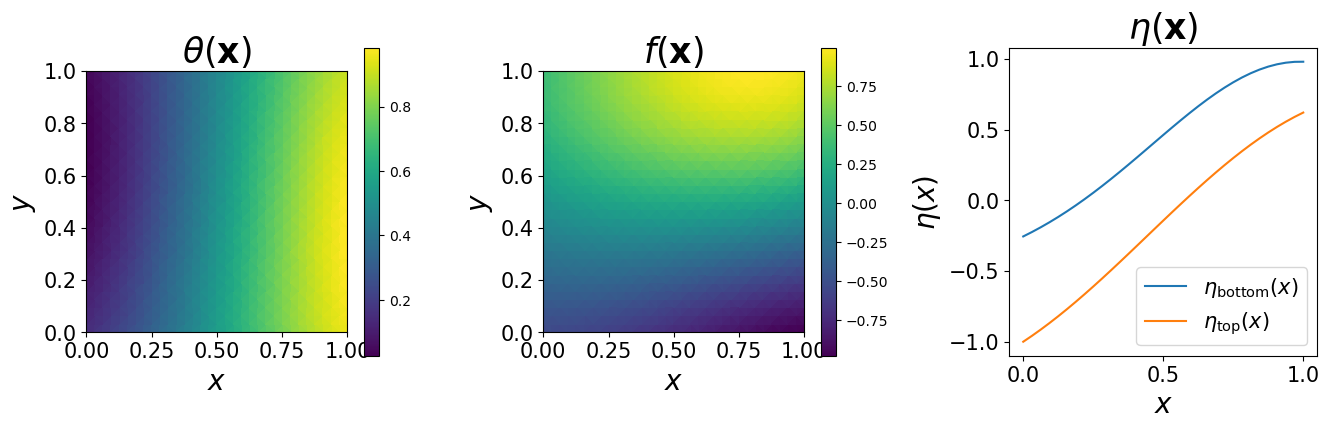

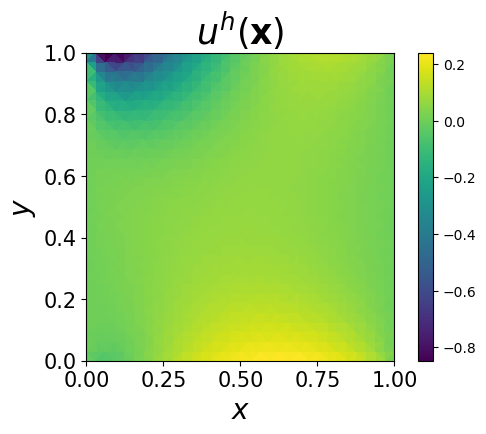

In [4]:
x = outputs['x']
u = outputs['u']
f = outputs['f']
theta = outputs['theta']
etab = outputs['etab']
etat = outputs['etat']

#plot
fig, axs = plt.subplots(1,3, figsize=(16, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 25
size_ticklabels = 15
size_axeslabels = 20

ax = axs[0]
plot0 = ax.tripcolor(x[:,0], x[:,1], theta)
ax.set_title(r"$\theta(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot0, ax=ax)

ax = axs[1]
plot1 = ax.tripcolor(x[:,0], x[:,1], f)
ax.set_title(r"$f(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

ax = axs[2]

ax.plot(x[x[:,1]==0,0], etab[x[:,1]==0], label=r'$\eta_\mathrm{bottom}(x)$')
ax.plot(x[x[:,1]==1,0], etat[x[:,1]==1], label=r'$\eta_\mathrm{top}(x)$')
ax.set_title(r"$\eta(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\eta(x)$', fontsize=size_axeslabels)
# ax.set_xlim(0,1)
ax.legend(fontsize=15)
ax.set_box_aspect(1)

# plt.savefig("hc2d_theta_f_eta.pdf", bbox_inches='tight')

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.tripcolor(x[:,0], x[:,1], u)
ax.set_title(r"$u^h(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("hc2d_u.pdf", bbox_inches='tight')


In [ ]:
data_postprocessed = postprocessdata(params, inputs, sample, outputs)
Theta = data_postprocessed['Theta']
F = data_postprocessed['F']
N = data_postprocessed['N']
x = data_postprocessed['x']
u = data_postprocessed['u']

In [ ]:
#plot
fig, axs = plt.subplots(1,3, figsize=(16, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 25
size_ticklabels = 15
size_axeslabels = 20

x_sensor, y_sensor = np.mgrid[0:1:np.sqrt(trainingdataparams['N_sensornodes'])*1j, 0:1:np.sqrt(trainingdataparams['N_sensornodes'])*1j]
ax = axs[0]
plot0 = ax.scatter(x_sensor, y_sensor, c=Theta.flatten())
ax.set_title(r"$\hat{\Theta}_j=\theta(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_aspect('equal')
fig.colorbar(plot0, ax=ax)

ax = axs[1]
plot1 = ax.scatter(x_sensor, y_sensor, c=F.flatten())
ax.set_title(r"$\hat{F}_j=f(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

ax = axs[2]
plot2 = ax.scatter(x_sensor, y_sensor, c=N.flatten(), norm=norm)
ax.set_title(r"$\hat{N}_j=\eta(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_aspect('equal')
fig.colorbar(plot2, ax=ax)

plt.savefig("hc2d_theta_f_eta_postprocessed.pdf", bbox_inches='tight')

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.scatter(x[:,0], x[:,1], c=u)
ax.set_title(r"$u^h_{jl}=u^h_j(\mathbf{x}_l)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("hc2d_u_postprocessed.pdf", bbox_inches='tight')
